# Step 1: Import Libraries

In [1]:
# Basic data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NLP libraries
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
# Machine Learning and metrics libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [4]:
# Download nltk stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Step 2: Load and Explore the Dataset

In [5]:
# Load the IMDB dataset
df = pd.read_csv('/content/drive/MyDrive/sentiment-analysis/IMDB Dataset.csv')


In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Step 3: Remove Duplicates and Visualize Sentiment Distribution

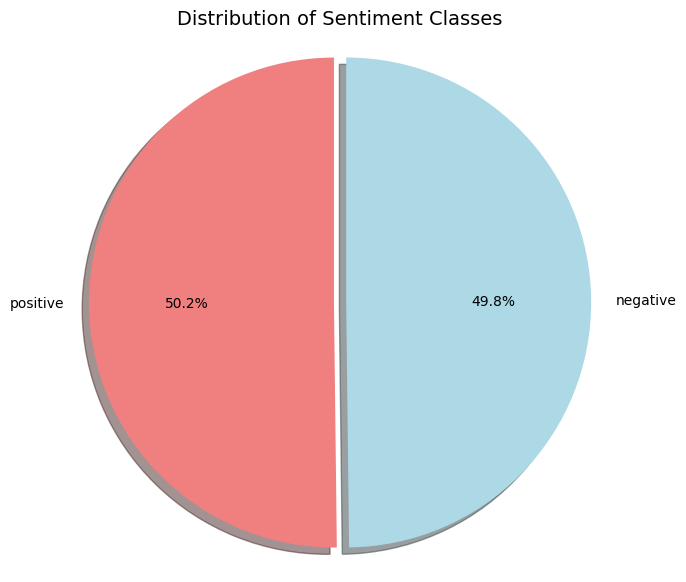

In [8]:
# Remove duplicates from the dataset
df.drop_duplicates(inplace=True)

# Calculate sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = sentiment_counts.index
sentiment_sizes = sentiment_counts.values

# Plot sentiment distribution as a pie chart
plt.figure(figsize=(7, 7))
plt.pie(sentiment_sizes, labels=sentiment_labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'], explode=(0.05, 0), shadow=True)
plt.title('Distribution of Sentiment Classes', fontsize=14)
plt.axis('equal')
plt.show()


# Step 4: Text Preprocessing

In [9]:
# Preprocess the text (lowercase, remove special characters, tokenize, remove stopwords, and stemming)
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['review'].apply(preprocess_text)

df[['review', 'cleaned_review']].head()


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one review mention watch 1 oz episod youll hoo...
1,A wonderful little production. <br /><br />The...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,basic there famili littl boy jake think there ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...


# Step 5: Visualize Frequent Words Before and After Preprocessing

<ipython-input-10-c87f1836c940>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orig_counts, y=orig_words, palette='coolwarm')
<ipython-input-10-c87f1836c940>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=preproc_counts, y=preproc_words, palette='viridis')


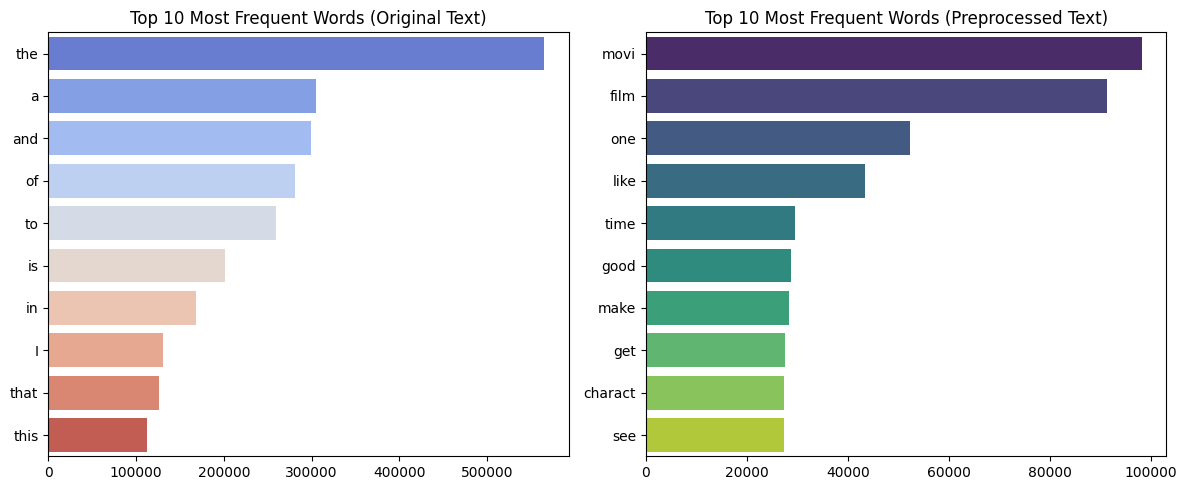

In [10]:
from collections import Counter

def get_word_frequencies(text_column):
    words = []
    for review in text_column:
        words.extend(review.split())
    return Counter(words)

# Get word frequencies for original and cleaned reviews
original_word_freq = get_word_frequencies(df['review'])
preprocessed_word_freq = get_word_frequencies(df['cleaned_review'])

# Get top 10 frequent words
original_common_words = original_word_freq.most_common(10)
preprocessed_common_words = preprocessed_word_freq.most_common(10)

orig_words = [word for word, count in original_common_words]
orig_counts = [count for word, count in original_common_words]

preproc_words = [word for word, count in preprocessed_common_words]
preproc_counts = [count for word, count in preprocessed_common_words]

# Plot word frequencies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=orig_counts, y=orig_words, palette='coolwarm')
plt.title('Top 10 Most Frequent Words (Original Text)')

plt.subplot(1, 2, 2)
sns.barplot(x=preproc_counts, y=preproc_words, palette='viridis')
plt.title('Top 10 Most Frequent Words (Preprocessed Text)')
plt.tight_layout()
plt.show()


# Step 6: TF-IDF Vectorization


Before training our machine learning models, we need to convert the text into numerical features. TF-IDF (Term Frequency-Inverse Document Frequency) is a common technique used for this. It helps assign importance to words based on their frequency in the document and across all documents.

In [11]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()

# Convert sentiments to binary (1 for positive, 0 for negative)
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (39665, 5000)
Testing set shape: (9917, 5000)


# Step 7: Train Logistic Regression Model

* In this step, we train a Logistic Regression model, which is a simple and effective binary classifier. We will then evaluate the model's performance using a confusion matrix and classification report.

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.87      0.90      0.89      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



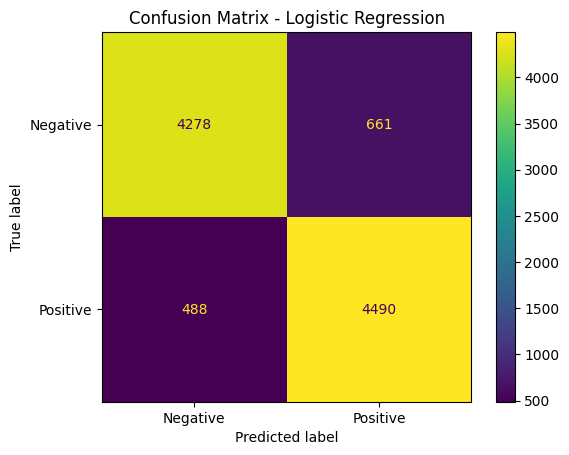

In [12]:
log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Display the confusion matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
ConfusionMatrixDisplay(cm_log_reg, display_labels=['Negative', 'Positive']).plot()
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


# Step 8: Save the Model and Vectorizer

In [13]:
import joblib

joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

# Step 9: User Interface for Prediction

In [14]:
!pip install ipywidgets

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [15]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [16]:

def preprocess_text_input(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)


def predict_sentiment(review):
    processed_review = preprocess_text_input(review)
    review_tfidf = loaded_vectorizer.transform([processed_review])
    prediction = loaded_model.predict(review_tfidf)
    if prediction == 1:
        return "Positive review 😊", "positive"
    else:
        return "Negative review 😞", "negative"




In [23]:
loaded_model = joblib.load('logistic_regression_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

input_box = widgets.Textarea(
    value='',
    placeholder='Type your movie review here...',
    description='Review:',
    layout=widgets.Layout(width='100%', height='100px'),
    style={'description_width': 'initial'}
)

submit_button = widgets.Button(
    description="Predict Sentiment",
    button_style='success',
    tooltip="Click to analyze sentiment"
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        review = input_box.value

        sentiment_result, sentiment_class = predict_sentiment(review)

        if sentiment_class == "positive":
            display(widgets.HTML(f"<h3 style='color:green;'>{sentiment_result}</h3>"))
        else:
            display(widgets.HTML(f"<h3 style='color:red;'>{sentiment_result}</h3>"))

submit_button.on_click(on_button_clicked)

display(input_box, submit_button, output)


Textarea(value='', description='Review:', layout=Layout(height='100px', width='100%'), placeholder='Type your …

Button(button_style='success', description='Predict Sentiment', style=ButtonStyle(), tooltip='Click to analyze…

Output()